# Processing corrected samples

Datasets typically consist of several wells on a microscopy slide. In this notebook, the wells are integrated to one annotated data matrix.

In [21]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
from src.functions import get_matrices_from_dfs, normalize_proportion_ratios
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.formula.api as smf
import seaborn as sns

In [22]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'
    
# this is the column of the annotated data matrix, that discriminates between conditions
condition_name = 'dataset_3'

In [23]:
samples = [dir.name for dir in os.scandir(target_path) if dir.is_dir() and dir.name[0] != "."]

files = {
        'cell_sm_matrix': 'cells_spatiomolecular_adata.h5ad',
        'corr_cell_sm_matrix': 'cells_spatiomolecular_adata_corrected.h5ad',
    }

After loading all individual wells, they are concatenated into one data matrix. Cell identifiers are kept unique by adding a well-specific suffix 

In [24]:
adata_dict = {}
adata_cor_dict = {}

for sample in samples:
    sample_path = os.path.join(target_path, sample)

    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    adata = sc.read(project_files['cell_sm_matrix'])
    adata_cor = sc.read(project_files['corr_cell_sm_matrix'])

    adata_dict[sample] = adata
    adata_cor_dict[sample] = adata_cor


In [25]:
def split_dataset_info(adata):
    split = adata.obs['dataset'].str.split("_", expand=True)
    adata.obs[['dataset_' + str(col) for col in split.columns]] = split

In [26]:
def concat_wells(adata_dict):
    adata = ad.concat(adata_dict, label='well', index_unique="_", merge="same")
    #sc.tl.pca(adata)
    #sc.external.pp.bbknn(adata, batch_key='well')
    split_dataset_info(adata)
    return adata

adata = concat_wells(adata_dict)
adata_cor = concat_wells(adata_cor_dict)


The combined data matrix contains cells of the following conditions:

In [33]:
adata.obs[condition_name].value_counts()

TMDdM        3499
NaiveWT      3149
TMDCD95WT    2479
TMDtM        1905
TMDsM        1676
TMDCD95KO    1208
TMDd\sM       410
TMDCD96KO     405
Name: dataset_3, dtype: int64

In [28]:
adata.write(os.path.join(target_path, "batch_sm_matrix.h5ad"))
adata_cor.write(os.path.join(target_path, "corrected_batch_sm_matrix.h5ad"))

Across conditions and wells, the ion suppression correction should not have varying influences on the ion intensities. Using the included positional and size information of the cell-based data matrices, one can observe potential dependencies in the data.

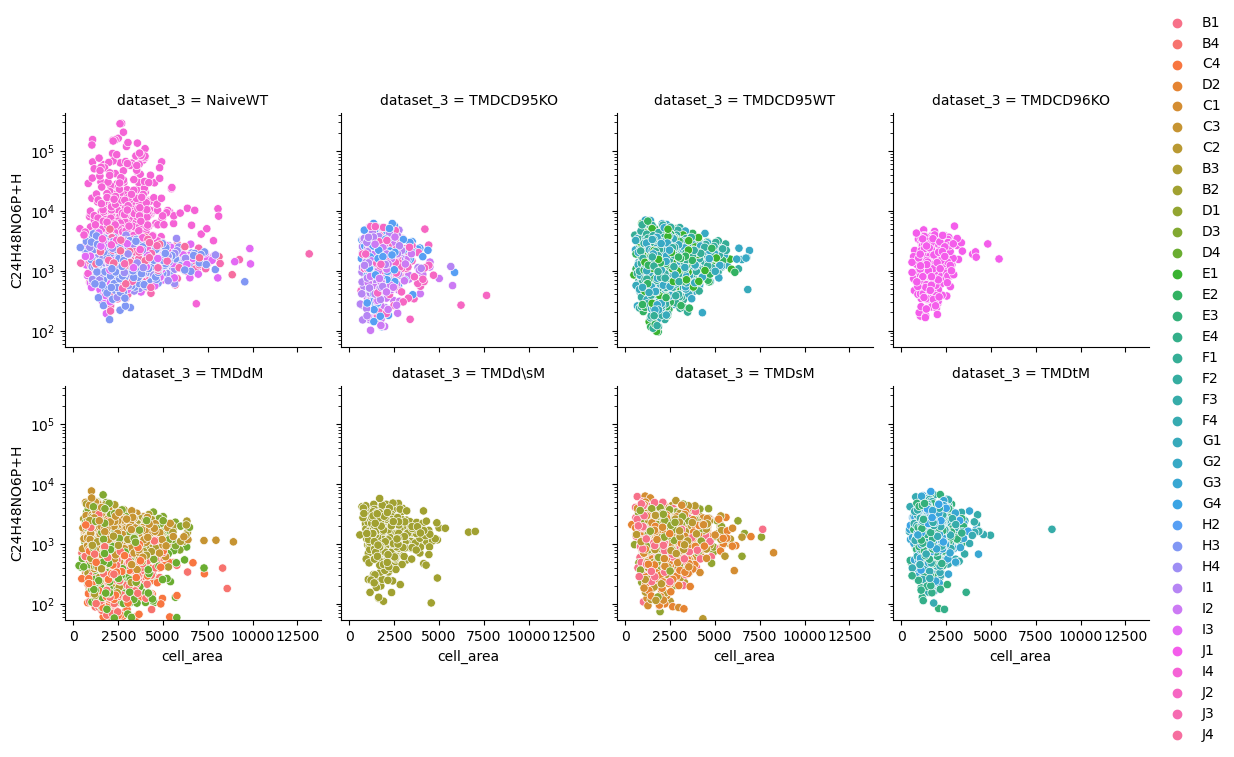

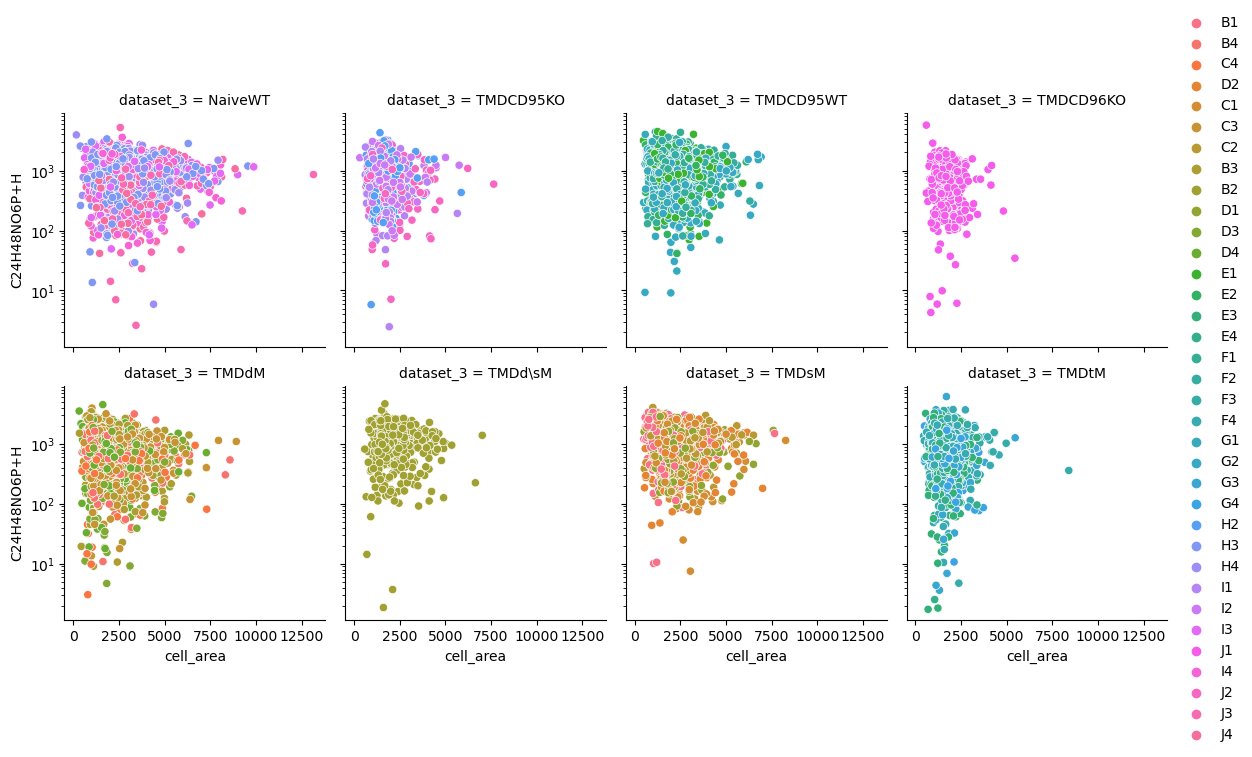

In [29]:
import warnings
warnings.filterwarnings('ignore')

def plot_by(adata, ion = 'C24H48NO6P+H', col = "dataset_3", x = 'cell_area', color = 'well'):
    plot_df = sc.get.obs_df(adata, keys=[col, ion, x, color])
    #plot_df = plot_df[plot_df[ion] > 0]
    graph = sns.FacetGrid(plot_df, col=col, col_wrap=4)
    graph.map(sns.scatterplot, x, ion, hue=plot_df[color]).add_legend().set(yscale='log')
                                         
plot_by(adata)
plot_by(adata_cor)

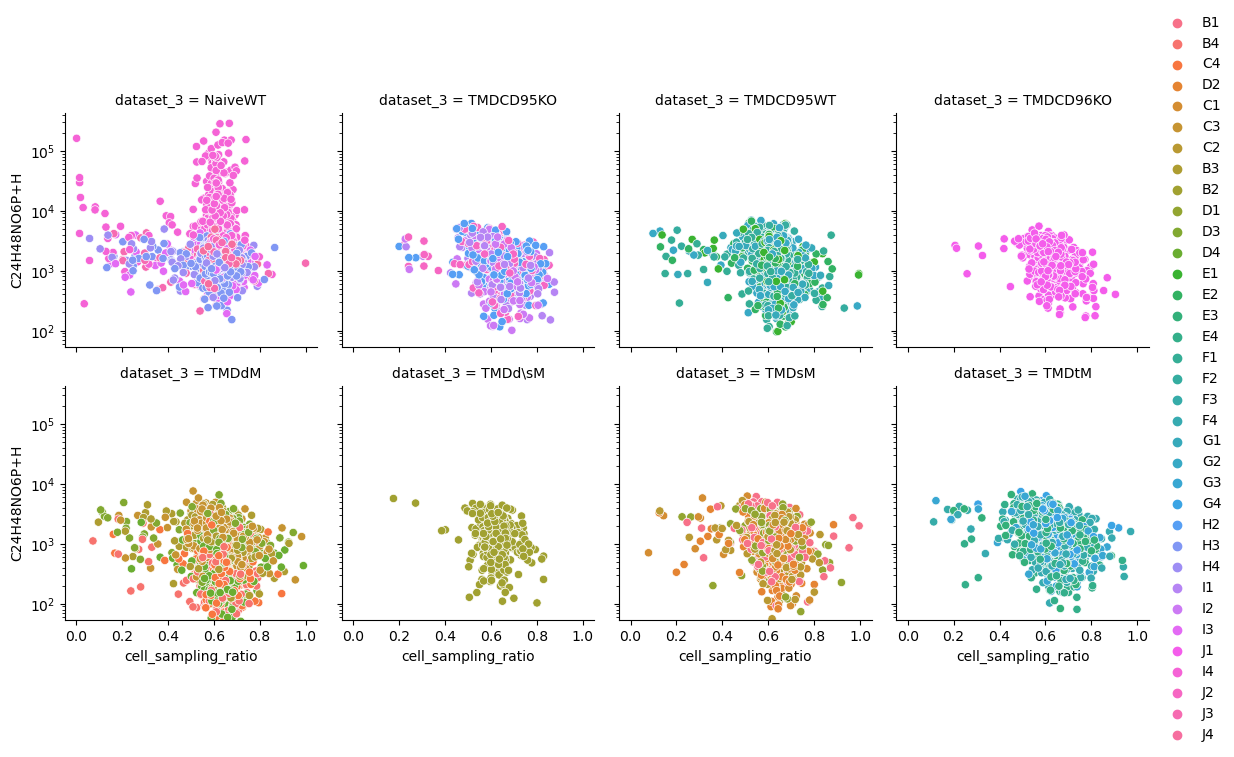

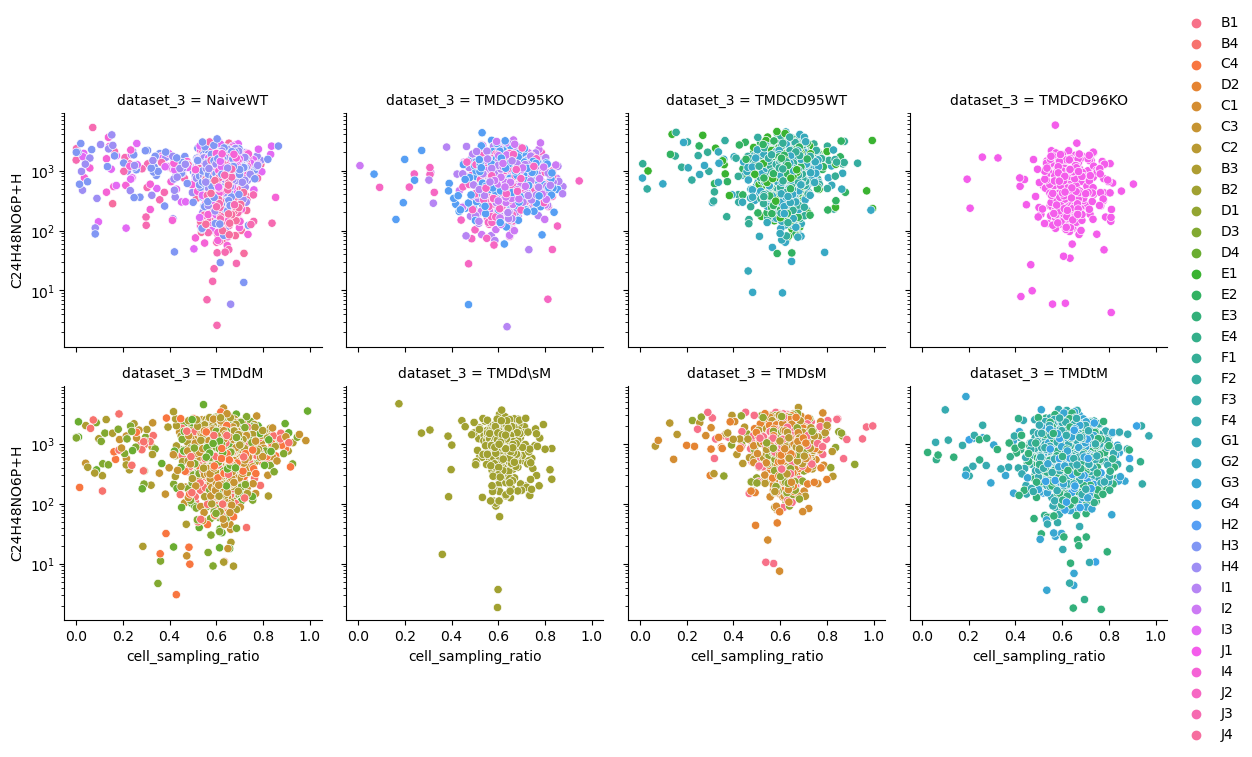

In [30]:
plot_by(adata, x = 'cell_sampling_ratio')
plot_by(adata_cor, x = 'cell_sampling_ratio')